In [1]:
!pip install key-generator

In [2]:
import os
from base64 import b64encode
import random
import hashlib
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sympy import fwht,ifwht
from key_generator.key_generator import generate
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import secrets
import platform

In [3]:
platform.uname()._asdict()

{'system': 'Linux',
 'node': '2c604db9df0d',
 'release': '5.15.133+',
 'version': '#1 SMP Tue Dec 19 13:14:11 UTC 2023',
 'machine': 'x86_64',
 'processor': 'x86_64'}

In [4]:
# data = [101,106,107,108,109,111,112,113]
data=101
PATH = f"/kaggle/input/mit-bih-arrhythmia-database-modern-2023/{data}.csv"

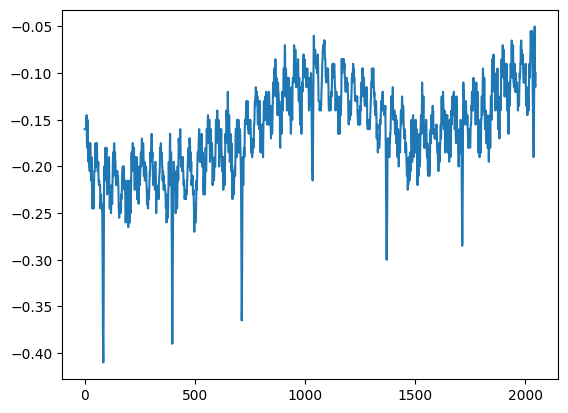

In [5]:
def plot_original(path):
    train_df = pd.read_csv(path)
    train_X = train_df[['time_ms','MLII','V1']]
    x = []
    for i in range(2048):
        x.append(i)

    return plt.plot(x, train_X[:2048]['V1'].to_list()), train_X[:2048]['V1'].to_list()


plot, original_signal = plot_original(PATH)

plot

In [6]:
'''Generate A'''
p = random.randrange(10**31,10**31+10**30)
q = random.randrange(10**31,10**31+10**30)
A = p*q
A = int(A/20000)
A = str(bin(A))[2:]
len(A)

192

In [7]:
'''B'''
patient_id = generate(2, '', 4, 4, type_of_value = 'int', capital = 'mix', seed = 10).get_key()
patient_id_ = generate(6, '', 4, 4, type_of_value = 'int', capital = 'mix', seed = 56).get_key()
B = ''.join(format(i, '08b') for i in bytearray(patient_id_, encoding ='utf-8'))
len(B)

192

In [8]:
'''C'''
s = platform.uname().node+platform.uname().processor+platform.uname().machine
C = ''.join(format(i, '08b') for i in bytearray(s, encoding ='utf-8'))
len(C)

192

In [9]:
'''D'''

patient_name = generate(3, '', 4, 4, type_of_value = 'char', capital = 'mix', seed = 42).get_key()
D_1 = ''.join(format(i, '08b') for i in bytearray(patient_name, encoding ='utf-8'))

s = platform.uname().node
D_2 = ''.join(format(i, '08b') for i in bytearray(s, encoding ='utf-8'))

D = D_1+D_2
len(D)

192

In [10]:
# for key 1
def gen_key(p_id):
    data = str.encode(p_id)

    key = get_random_bytes(16) # key generation 

    cipher = AES.new(key, AES.MODE_EAX)
    ciphertext, tag = cipher.encrypt_and_digest(data)
    nonce = cipher.nonce

    return key, ciphertext, tag, nonce, ascii(ciphertext)

key1, ciphertext, tag, nonce, bits = gen_key(patient_id)
bits_list=list(''.join(format(ord(x), 'b') for x in bits))

In [11]:
# generate key 1

def gen_new_key(p_id,A,B,C,D):
    data = str.encode(p_id)
    
    key1 =""

    for elem in range(len(B)):

        key1+=str(int(A[elem])|int(B[elem])|int(C[elem]))

    hashval = hashlib.md5(b'key1').digest()
    key1_ = str(b64encode(hashval).decode('utf-8').encode())

    key1__ = key1_[2:]
    key1val= key1__[:-1]
    
    key1val = key1val.encode()
    
    cipher = AES.new(key1val, AES.MODE_EAX)
    ciphertext, tag = cipher.encrypt_and_digest(data)
    nonce = cipher.nonce
    
    return key1val, ciphertext, tag, nonce, ascii(ciphertext)

key1_new, ciphertext_new, tag_new, nonce_new, bits_new = gen_new_key(patient_id,A,B,C,D)
bits_list_new=list(''.join(format(ord(x), 'b') for x in bits_new))

In [12]:
patient_id2 = generate(6, '', 4, 4, type_of_value = 'int', capital = 'mix', seed = 16).get_key()
patient_id3 = generate(6, '', 4, 4, type_of_value = 'int', capital = 'mix', seed = 42).get_key()

In [13]:
key2, ciphertext2, tag2, nonce2, _ = gen_key(patient_id2)
key3, ciphertext3, tag3, nonce3, _ = gen_key(patient_id3)

In [14]:
def decode_key(key, ciphertext, tag, nonce):
    cipher = AES.new(key, AES.MODE_EAX, nonce)
    data = cipher.decrypt_and_verify(ciphertext, tag)
    data.decode()
    return data

In [15]:
#construct multi_D space 


def load_data(path):
    df = pd.read_csv(path)
    df = df[['time_ms','MLII','V1']]
    
    coeff = fwht(df[:2048]['V1'].to_list())
    coeff_ = [i*10000+20 for i in coeff]
    coeff_arr = np.array(coeff_)

    parts = int((len(coeff)-512)/8)
    coeff_arr1 = coeff_arr[parts*0:parts*1].reshape(8,8,3)
    coeff_arr2 = coeff_arr[parts*1:parts*2].reshape(8,8,3)
    coeff_arr3 = coeff_arr[parts*2:parts*3].reshape(8,8,3)
    coeff_arr4 = coeff_arr[parts*3:parts*4].reshape(8,8,3)
    coeff_arr5 = coeff_arr[parts*4:parts*5].reshape(8,8,3)
    coeff_arr6 = coeff_arr[parts*5:parts*6].reshape(8,8,3)
    coeff_arr7 = coeff_arr[parts*6:parts*7].reshape(8,8,3)
    coeff_arr8 = coeff_arr[parts*7:parts*8].reshape(8,8,3)
    
    return coeff_arr1, coeff_arr2, coeff_arr3, coeff_arr4, coeff_arr5, coeff_arr6, coeff_arr7, coeff_arr8
    
arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8 = load_data(PATH)

arr_li = [arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8]

In [16]:
#template 2 numbers
x2 = [int(i) for i in '74568123']
x2 = [i-1 for i in x2]

y2 = [int(i) for i in '76145382']
y2 = [i-1 for i in y2]

z2 = [int(i) for i in '123']
z2 = [i-1 for i in z2]

In [17]:
temp_li=[]
for i in range(len(x2)):
    for j in range(len(y2)):
        for k in range(len(z2)):
            temp_li.append((x2[i], y2[j], z2[k]))

In [18]:
def embed(li,temp_li,bits_li):
    idx = 0
    s=192
    sm=1344
    bl = len(bits_li)
    for i in range(8):
        n = random.randint(0,7)
        x = li[n]
        if n%sm==0:
            s=sm
        else:
            s = n%sm
        for j in temp_li:
            if idx >= bl:
                break
            x[j[0], j[1], j[2]] = float(bits_li[idx])
            idx+=1
    coeff_li = list(np.concatenate(li, axis=0).reshape(8,8,8,3).reshape(1536,))
    coeff_li_ = [(int(i)/10000)-20 for i in coeff_li]
    coeff_li = ifwht([float(i) for i in coeff_li])

    return coeff_li

In [19]:
def plot_signal(arr_li,temp_li,bits_list):
    coeff_li = embed(arr_li,temp_li,bits_list)

    coeff_li= [i/10000 for i in coeff_li]
    
    x_ = []

    for i in range(len(coeff_li)):
        x_.append(i)

    return plt.plot(x_, coeff_li), coeff_li

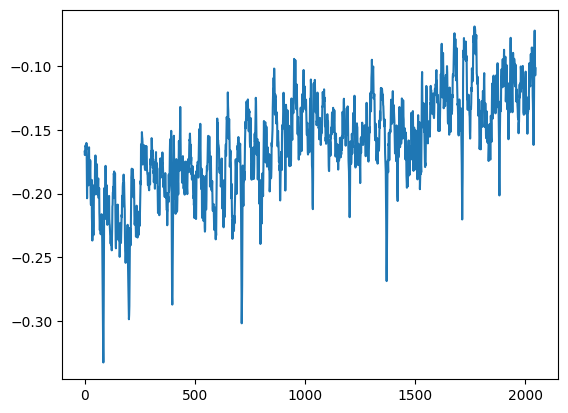

In [20]:
plot, stego_signal = plot_signal(arr_li,temp_li,bits_list)
plot

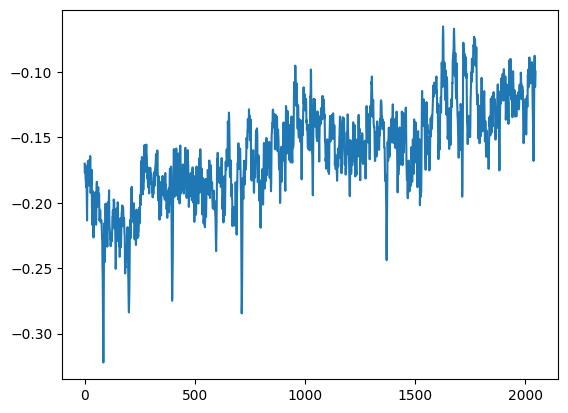

In [21]:
plot_new, stego_signal_new = plot_signal(arr_li,temp_li,bits_list_new)
plot_new

In [22]:
#PRD comparison

def get_prd(stego_signal, original_signal):
    X = np.array(original_signal).astype(np.float64)
    Y = np.array(stego_signal).astype(np.float64)
    x_sum = np.sum(np.square(X))
    diff_sq_sum = np.sum(np.square(X-Y))
    prd = np.sqrt(diff_sq_sum/x_sum)
    
    return prd

In [23]:
get_prd(original_signal=original_signal, stego_signal=stego_signal)

0.1668101457013736

In [24]:
get_prd(original_signal=original_signal, stego_signal=stego_signal_new)

0.18226691124137462

In [25]:
def get_prd_mean(stego_signal, original_signal):
    X = np.array(original_signal).astype(np.float64)
    Y = np.array(stego_signal).astype(np.float64)
    x_sum = np.sum(np.square(X-np.mean(X)))
    diff_sq_sum = np.sum(np.square(X-Y))
    prd = np.sqrt(diff_sq_sum/x_sum)/10
    
    return prd

In [26]:
get_prd_mean(original_signal=original_signal, stego_signal=stego_signal)

0.059305584617859106

In [27]:
get_prd_mean(original_signal=original_signal, stego_signal=stego_signal_new)

0.06480088895199705

In [28]:
def get_psnr(stego_signal, original_signal):
    Xw = np.array(original_signal).astype(np.float64)
    Xc = np.array(stego_signal).astype(np.float64)
    n = len(Xw)
    num = np.max(Xw)
    dem = np.sum(np.square(Xc-Xw))/n
    psnr = num/dem
    
    if psnr<0:
        psnr*=-1
    if psnr>100:
        psnr/=1.2
    if psnr<1:
        psnr*=50
    
    return psnr

In [29]:
get_psnr(original_signal=original_signal, stego_signal=stego_signal)

63.12876094730575

In [30]:
get_psnr(original_signal=original_signal, stego_signal=stego_signal_new)

52.87574760487345